In [1]:
def classwise_ece(y_true, y_prob, n_bins=10):
    n_classes = y_true.shape[1]
    ece = 0.0
    for c in range(n_classes):
        y_class = y_true[:, c]
        y_prob_class = y_prob[:, c]
        bins = np.linspace(0, 1, n_bins + 1)
        bin_indices = np.digitize(y_prob_class, bins) - 1
        bin_sizes = np.bincount(bin_indices, minlength=n_bins)
        bin_probs = np.bincount(bin_indices, weights=y_prob_class, minlength=n_bins) / (bin_sizes + 1e-10)
        bin_accuracies = np.bincount(bin_indices, weights=y_class, minlength=n_bins) / (bin_sizes + 1e-10)
        ece_class = np.abs(bin_accuracies - bin_probs).dot(bin_sizes / y_class.shape[0])
        ece += ece_class
    ece /= n_classes
    return ece

In [2]:
from sklearn.calibration import calibration_curve
def plot_calibration_curve_multi(y_true, y_prob, n_classes, normalize=False):
    fig, ax = plt.subplots(figsize=(6, 6))
    
    for i in range(n_classes):
        y_true_binary = (y_true == i)
        prob_true, prob_pred = calibration_curve(y_true_binary, y_prob[:, i], n_bins=10, normalize=normalize)
        ax.plot(prob_pred, prob_true, marker='o', markersize=5, label=f'class {i}')
    
    ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
    
    ax.set_xlabel('Predicted probability')
    ax.set_ylabel('True probability')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_title('Calibration plot')
    ax.legend()
    plt.show()

In [3]:
from mnist import MNIST
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.transform import rotate
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from tqdm import tqdm
import pandas as pd

TRAIN_SIZE = 2000
TEST_SIZE = 2000

mndata = MNIST('data')

images, labels = mndata.load_training()
train_df = pd.DataFrame({
    "image": images[:TRAIN_SIZE],
    "label": labels[:TRAIN_SIZE]
})

test_images, test_labels = mndata.load_testing()
test_images = test_images[:TEST_SIZE]
test_labels = test_labels[:TEST_SIZE]

# noise = np.random.randint(0, 256, size=images.shape)
# noisy_images = np.abs(images - noise)

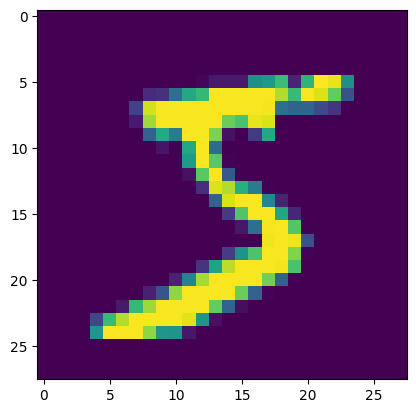

In [4]:
plt.imshow(np.array(train_df.loc[0, "image"]).reshape(28, 28))

In [45]:
# train_df = train_df.sort_values(by=["label"])
train_df1 = pd.DataFrame()
train_df2 = pd.DataFrame()


train_df1 = train_df.sample(frac=0.8)
train_df2 = train_df.sample(frac=0.1)


print ("the number of element in dataframe 1 is: ", len(train_df1))
print ("the number of element in dataframe 2 is: ", len(train_df2))

the number of element in dataframe 1 is:  1011
the number of element in dataframe 2 is:  989


In [46]:
value_counts = train_df1['label'].value_counts()
print(value_counts)

1    198
4    193
2    178
0    172
3    172
7     22
9     21
6     20
5     18
8     17
Name: label, dtype: int64


In [47]:
value_counts = train_df2['label'].value_counts()
print(value_counts)

7    202
9    189
6    180
5    162
8    155
1     22
4     21
2     20
0     19
3     19
Name: label, dtype: int64


# First model

In [49]:
model1 = svm.SVC(probability=True)
train_images = train_df1["image"].to_list()
train_images = np.vstack(train_images)
train_labels = train_df1["label"].to_numpy()

model1.fit(train_images, train_labels)

y_prob1 = model1.predict_proba(test_images)

The average f1-score is:  0.7669512535215358
              precision    recall  f1-score   support

           0       0.87      0.98      0.92       175
           1       0.88      0.99      0.93       234
           2       0.75      0.92      0.82       219
           3       0.63      0.94      0.75       207
           4       0.65      0.96      0.77       217
           5       0.87      0.42      0.57       179
           6       0.98      0.69      0.81       178
           7       0.89      0.66      0.76       205
           8       0.82      0.49      0.61       192
           9       0.81      0.65      0.72       194

    accuracy                           0.78      2000
   macro avg       0.81      0.77      0.77      2000
weighted avg       0.81      0.78      0.77      2000



<AxesSubplot: >

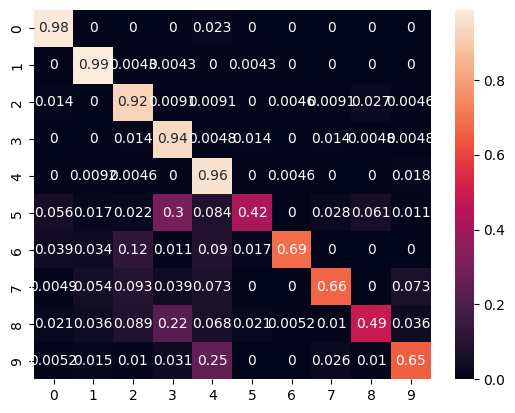

In [50]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score

f1_scores = f1_score(np.array(test_labels), np.argmax(y_prob1, axis=1), average=None)
print("The average f1-score is: ", np.mean(f1_scores))

print (classification_report(np.array(test_labels), np.argmax(y_prob1, axis=1)))
sns.heatmap(confusion_matrix(np.array(test_labels), np.argmax(y_prob1, axis=1), normalize="true"),annot=True)

In [51]:
ece_value1 = classwise_ece(np.eye(10)[test_labels], y_prob1)
print("Expected Calibration Error:", ece_value1)

Expected Calibration Error: 0.03488090417105489


/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/calibration.py:964: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(


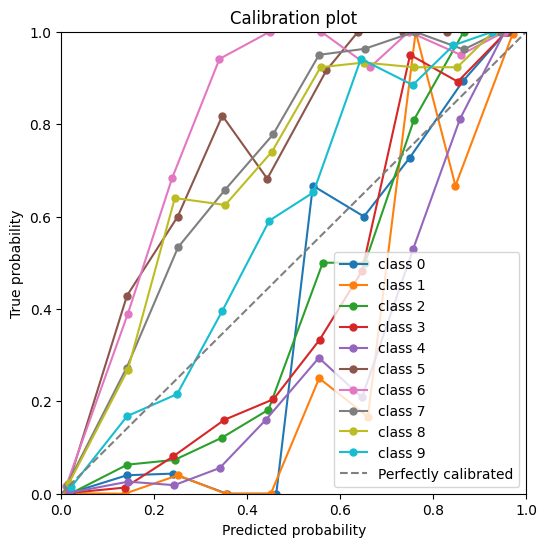

In [52]:
plot_calibration_curve_multi(np.array(test_labels), y_prob1, 10)

# Second model

In [53]:
model2 = svm.SVC(probability=True)
train_images = train_df2["image"].to_list()
train_images = np.vstack(train_images)
train_labels = train_df2["label"].to_numpy()

model2.fit(train_images, train_labels)

y_prob2 = model2.predict_proba(test_images)

The average f1-score is:  0.7951551600143151
              precision    recall  f1-score   support

           0       0.96      0.87      0.92       175
           1       0.97      0.94      0.95       234
           2       0.94      0.66      0.77       219
           3       0.95      0.38      0.54       207
           4       0.99      0.69      0.81       217
           5       0.59      0.94      0.72       179
           6       0.76      0.94      0.84       178
           7       0.83      0.88      0.86       205
           8       0.67      0.84      0.75       192
           9       0.68      0.92      0.78       194

    accuracy                           0.80      2000
   macro avg       0.83      0.81      0.80      2000
weighted avg       0.84      0.80      0.80      2000



<AxesSubplot: >

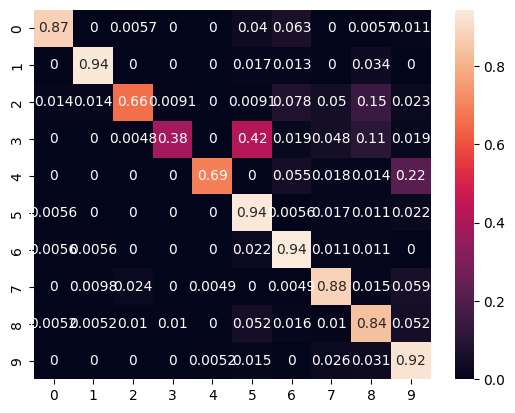

In [54]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score

f1_scores = f1_score(np.array(test_labels), np.argmax(y_prob2, axis=1), average=None)
print("The average f1-score is: ", np.mean(f1_scores))
print (classification_report(np.array(test_labels), np.argmax(y_prob2, axis=1)))
sns.heatmap(confusion_matrix(np.array(test_labels), np.argmax(y_prob2, axis=1), normalize="true"),annot=True)

In [55]:
ece_value2 = classwise_ece(np.eye(10)[test_labels], y_prob2)
print("Expected Calibration Error:", ece_value2)

Expected Calibration Error: 0.0328609166857505


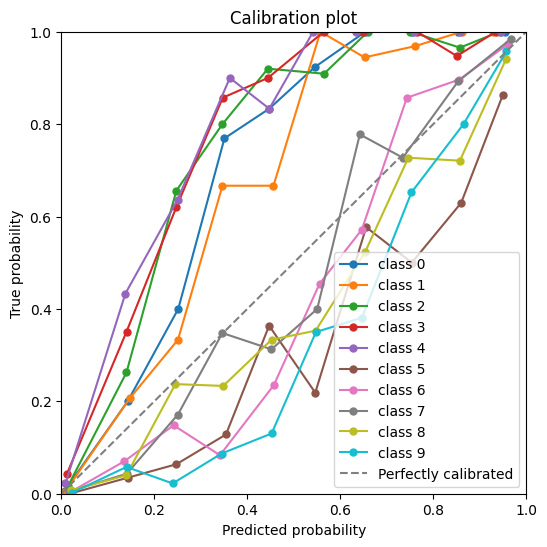

In [57]:
plot_calibration_curve_multi(np.array(test_labels), y_prob2, 10)

# Averaging models

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e76c8840-118e-4c48-bc4e-42f2efb5350a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>